In [16]:
# import Libraries
from datetime import datetime #=> date time conversion on dataframe
import re
 
# Dataframe
import pandas as pd
 
# Numerical
import numpy as np
from math import sqrt
 
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns 

 
# Model
import sklearn
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error, r2_score
from keras.layers.recurrent import GRU
from keras import optimizers
 
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
 
pd.options.mode.chained_assignment = None #https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html

In [4]:
print (pd.__version__)

1.2.4


In [7]:
print (np.__version__)

1.19.5


In [11]:
print (tf.__version__)

2.6.0


In [15]:
print (sklearn.__version__)

0.24.1


In [19]:
print (sns.__version__)

0.11.1


### LSTM

In [2]:
def fit_model(train, val, timesteps, hl, lr, batch, epochs):
  '''
   Split data train ==> X_train & y_train
   Split validation data ==> X_val & y_val
   Initiation of neural network model (RNN LSTM)
   Fitting/ Training data

  Parameter:
    train = train dataframe (which has not been separated by X & y)
    val = validation dataframe (which has not been separated by X & y)
    timesteps = sequence
    hl = hidden layer
    lr = learning rate
    batch = mini batch for iteration
    epochs = sum of iteration

  Returns:
    model = LSTM model training results
    model[loss] = loss value of training results
    model[val_loss] = loss value validation result
  '''
  X_train = []
  Y_train = []
  X_val = []
  Y_val = []


  # Loop for training data
  # Index: 0 (Open), 1 (High), 2 (Low),....6 (Close)
  for i in range(timesteps,train.shape[0]):
      X_train.append(train[i-timesteps:i]) # List
      Y_train.append(train[i][6]) # <== Index 6 (CLOSE) bisa juga -1
  X_train, Y_train = np.array(X_train), np.array(Y_train) # Transform list to numpy array

  # Loop for val data
  for i in range(timesteps,val.shape[0]):
      X_val.append(val[i-timesteps:i])
      Y_val.append(val[i][6]) # <== Index 6 (CLOSE), bisa juga -1
  X_val, Y_val = np.array(X_val), np.array(Y_val)
  
  
  # Setting up an early stop
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
  callbacks_list = [earlystop]
  
  # Adding Layers to the model
  model = Sequential()

  #Arsitektur
  model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                  activation = 'relu'))

  for i in range(len(hl)-1):        
      model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
      model.add(Dropout(0.2))
  
  # Hidden layer
  model.add(LSTM(hl[-1],activation = 'relu'))
  model.add(Dropout(0.2))  

  #output Layer
  model.add(Dense(1)) #Close prediction [3]
  
  #optimizer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=lr), loss = 'mean_squared_error', metrics = ['accuracy'])
  

  # Training the data
  history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                      shuffle = False, callbacks=callbacks_list)
  print(model.summary())
  model.reset_states()
  return model, history.history['loss'], history.history['val_loss'], history

In [3]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  X_test = []
  Y_test = []

  # Loop for testing data
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i])
      Y_test.append(test[i][6]) # <== Index 6 (CLOSE)
  X_test,Y_test = np.array(X_test), np.array(Y_test)
  

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  mse = mean_squared_error(Y_test,Y_hat)
  rmse = sqrt(mse)
  r = r2_score(Y_test,Y_hat)
  return  mse, rmse, r, Y_test, Y_hat

In [4]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,test_data):
  date = test_data.reset_index()['Date']
  plt.figure(figsize=(15, 4))
  plt.plot(date, Y_test,c = 'r')
  plt.plot(date, Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.xticks(rotation=45)
  plt.ylabel('Price')
  plt.title('Close Price Stock Prediction Graph using Multivariate-LSTM model')
  plt.legend(['Actual','Predicted'],loc = 'lower right')
  plt.show()

In [5]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
  plt.plot(train_loss,c = 'r')
  plt.plot(val_loss,c = 'b')
  plt.ylabel('Loss')
  plt.legend(['train','val'],loc = 'upper right')
  plt.show()

In [6]:
#Open dataset from preprocessing
df = pd.read_csv('Output_macro_BBRI.csv')
df['Date'] = pd.to_datetime(df['Date'])
print(f'{np.min(df.Date)} until {np.max(df.Date)}')

2016-04-21 00:00:00 until 2020-12-30 00:00:00


In [7]:
# Extracting the series
df = df.set_index('Date')
df = df.dropna() # Drop menghindari Explosion Gradient (LSTM syarat: non NaN)

In [8]:
# Picking the multivariate series 
variables = ['Open', 'High', 'Low', 'Kurs', 'BI-7Day-RR', 'Data Inflasi', 'Close'] #close -1 index
series = df[variables] 
print(series.shape)
print(series)

(1185, 7)
              Open    High     Low     Kurs  BI-7Day-RR  Data Inflasi   Close
Date                                                                         
2016-04-21  2145.0  2145.0  2100.0  13182.0        5.50      3.550820  2140.0
2016-04-22  2140.0  2185.0  2130.0  13169.0        5.50      3.548361  2180.0
2016-04-25  2170.0  2175.0  2080.0  13235.0        5.50      3.540984  2100.0
2016-04-26  2090.0  2090.0  2010.0  13215.0        5.50      3.538525  2040.0
2016-04-27  2030.0  2065.0  2025.0  13173.0        5.50      3.536066  2040.0
...            ...     ...     ...      ...         ...           ...     ...
2020-12-22  4240.0  4280.0  4120.0  14218.0        3.75      1.680000  4130.0
2020-12-23  4150.0  4180.0  3950.0  14282.0        3.75      1.680000  4160.0
2020-12-28  4250.0  4260.0  4160.0  14184.0        3.75      1.680000  4250.0
2020-12-29  4250.0  4280.0  4170.0  14169.0        3.75      1.680000  4180.0
2020-12-30  4190.0  4210.0  4130.0  14105.0        3.7

### Modelling LSTM

In [9]:
import datetime as dt
# Note : 2016-04-21 00:00:00 until 2020-12-30 00:00:00 [1186 rows x 7 columns]
# Train Data (around 70%)
train_start = dt.date(2016, 4, 21)
train_end = dt.date(2019, 7, 31)
train_data = series.loc[train_start:train_end] # Output Train Data

# Validation Data (around 20%)
val_start = dt.date(2019, 8, 1)
val_end = dt.date(2020, 6, 30)
val_data = series.loc[val_start:val_end] # Output Validation Data

# Test Data (around 10%)
test_start = dt.date(2020, 7, 1)
test_end = dt.date(2020,12,31)
test_data = series.loc[test_start:test_end] # Output Test Data

print(f"Train Data:      {train_start}:{train_end}")
print(f"Validation Data: {val_start}:{val_end}")
print(f"Test Data:       {test_start}:{test_end}")
print('---------')
print(train_data.shape,val_data.shape,test_data.shape)

#ROT [70-20-10]

Train Data:      2016-04-21:2019-07-31
Validation Data: 2019-08-01:2020-06-30
Test Data:       2020-07-01:2020-12-31
---------
(837, 7) (227, 7) (121, 7)


In [10]:
# Normalization
# StandardScaler, RobustScaler
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(837, 7) (227, 7) (121, 7)


In [11]:
# LSTM Hyperparameters 
timesteps = 3
hl = [32, 32, 32]
lr = 0.001
batch_size = 64
num_epochs = 25

Epoch 1/25
14/14 [==============================] - 6s 71ms/step - loss: 0.2545 - accuracy: 0.0012 - val_loss: 0.5361 - val_accuracy: 0.0000e+00
Epoch 2/25
14/14 [==============================] - 0s 10ms/step - loss: 0.2194 - accuracy: 0.0012 - val_loss: 0.4745 - val_accuracy: 0.0000e+00
Epoch 3/25
14/14 [==============================] - 0s 10ms/step - loss: 0.1773 - accuracy: 0.0012 - val_loss: 0.3966 - val_accuracy: 0.0000e+00
Epoch 4/25
14/14 [==============================] - 0s 10ms/step - loss: 0.1278 - accuracy: 0.0012 - val_loss: 0.2961 - val_accuracy: 0.0000e+00
Epoch 5/25
14/14 [==============================] - 0s 9ms/step - loss: 0.0766 - accuracy: 0.0012 - val_loss: 0.1813 - val_accuracy: 0.0000e+00
Epoch 6/25
14/14 [==============================] - 0s 10ms/step - loss: 0.0550 - accuracy: 0.0012 - val_loss: 0.1100 - val_accuracy: 0.0134
Epoch 7/25
14/14 [==============================] - 0s 10ms/step - loss: 0.0643 - accuracy: 0.0012 - val_loss: 0.0949 - val_accuracy: 0

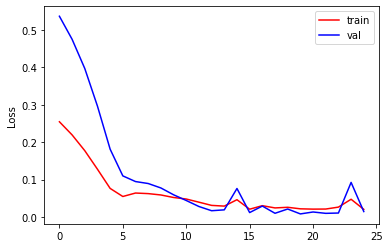

In [12]:
model, train_error, val_error, history = fit_model(train, val, timesteps, hl, lr, batch_size, num_epochs) #training
plot_error(train_error,val_error)

In [13]:
mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

MSE = 0.01539597751725674
RMSE = 0.12408052835661501
R-Squared Score = 0.47938860092980184


In [14]:
# Get each date data
train_date = train_data.index
val_date = val_data.index
test_date = test_data.index[timesteps:]

# Bring back onto original values
train_sc = sc.inverse_transform(train)
val_sc = sc.inverse_transform(val)
test_sc = sc.inverse_transform(test)

# Create empty fill so predicted data fits with scaler dimension
zeros_shape = test.shape[0] - timesteps
num_x_variables = len(variables) - 1
empty_fill = np.zeros((zeros_shape, num_x_variables))

# Transform back into original value
pred = np.concatenate((empty_fill, predicted), axis=1)
pred = sc.inverse_transform(pred)

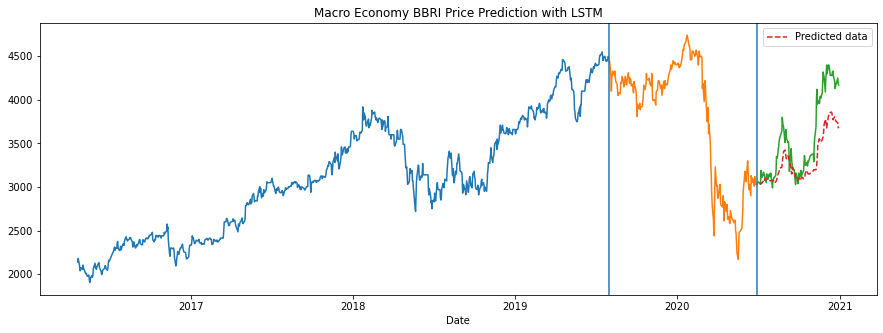

In [15]:
# Figure size
plt.figure(figsize=(15, 5))

# Train data
plt.plot(train_date, train_sc[:, 6])

# Val data
plt.plot(val_date, val_sc[:, 6])

# Test data
plt.plot(test_data.index, test_sc[:, 6])
plt.plot(test_date, pred[:, 6], label='Predicted data', linestyle='--')

# Boundaries
plt.axvline(np.max(train_date))
plt.axvline(np.max(val_date))

# Attributes
plt.title('Macro Economy BBRI Price Prediction with LSTM')
plt.xlabel('Date')
plt.legend()
plt.show()

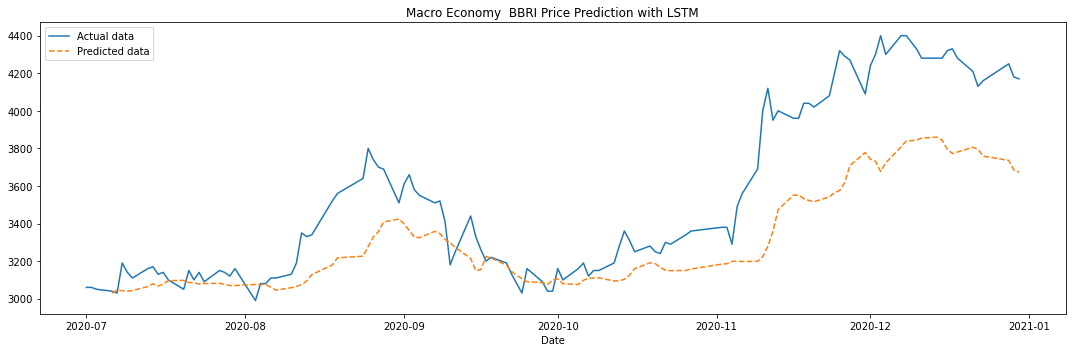

In [16]:
plt.figure(figsize=(15, 5))

# Test data
plt.plot(test_data.index, test_sc[:, 6], label='Actual data')
plt.plot(test_date, pred[:, 6], label='Predicted data', linestyle='--')

# Attributes
plt.title('Macro Economy  BBRI Price Prediction with LSTM')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

# GRU

In [17]:
#Build and train the model
def fit_model(train,val,timesteps,hl,lr,batch,epochs):
  X_train = []
  Y_train = []
  X_val = []
  Y_val = []

  # Loop for training data
  for i in range(timesteps,train.shape[0]):
      X_train.append(train[i-timesteps:i])
      Y_train.append(train[i][6])
  X_train,Y_train = np.array(X_train),np.array(Y_train)
  print(X_train.shape)
  # Loop for val data
  for i in range(timesteps,val.shape[0]):
      X_val.append(val[i-timesteps:i])
      Y_val.append(val[i][6])
  X_val,Y_val = np.array(X_val),np.array(Y_val)

  # Setting up an early stop
  earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=150,  verbose=1, mode='min')
  callbacks_list = [earlystop]
  
  # Adding Layers to the model
  model = Sequential()

  # Arsitektur 
  model.add(GRU(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                activation = 'relu'))
    
  for i in range(len(hl)-1):        
      model.add(GRU(hl[i],activation = 'relu',return_sequences = True))
      model.add(Dropout(0.2))
    
  model.add(GRU(hl[-1],activation = 'relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1))

  # Optimizer
  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr), loss = 'mean_squared_error')

  # Training the data
  history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,validation_data = (X_val, Y_val),verbose = 1,
                      shuffle = False, callbacks=callbacks_list)
  print(model.summary())
  model.reset_states()
  return model, history.history['loss'], history.history['val_loss']

In [18]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
  X_test = []
  Y_test = []

  # Loop for testing data
  for i in range(timesteps,test.shape[0]):
      X_test.append(test[i-timesteps:i])
      Y_test.append(test[i][6]) # <== Index 6 (CLOSE)
  X_test,Y_test = np.array(X_test),np.array(Y_test)

  # Prediction Time !!!!
  Y_hat = model.predict(X_test)
  mse = mean_squared_error(Y_test,Y_hat)
  rmse = sqrt(mse)
  r2 = r2_score(Y_test,Y_hat)
  return mse,rmse, r2, Y_test, Y_hat

In [19]:
# Plotting the predictions
def plot_data(Y_test,Y_hat,test_data):
  date = test_data.reset_index()['Date']
  plt.figure(figsize=(15, 4))
  plt.plot(date, Y_test,c = 'r')
  plt.plot(date, Y_hat,c = 'y')
  plt.xlabel('Day')
  plt.xticks(rotation=45)
  plt.ylabel('Price')
  plt.title('Close Price Stock Prediction Graph using Multivariate-GRU model')
  plt.legend(['Actual','Predicted'],loc = 'lower right')
  plt.show()

In [20]:
# Plotting the training errors
def plot_error(train_loss,val_loss):
  plt.plot(train_loss,c = 'r')
  plt.plot(val_loss,c = 'b')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.title('Loss Plot')
  plt.legend(['train','val'],loc = 'lower right')
  plt.show()

### Modelling GRU

In [21]:
import datetime as dt
# Note : 2016-04-21 00:00:00 until 2020-12-30 00:00:00.[1186 rows x 7 columns]
# Train Data (around 70%)
train_start = dt.date(2016,4,21)
train_end = dt.date(2019,7,31)
train_data = series.loc[train_start:train_end] # Output Train Data

# Validation Data (around 20%)
val_start = dt.date(2019,8,1)
val_end = dt.date(2020,6,30)
val_data = series.loc[val_start:val_end] # Output Validation Data

# Test Data (around 10%)
test_start = dt.date(2020,7,1)
test_end = dt.date(2020,12,31)
test_data = series.loc[test_start:test_end] # Output Test Data

print(f"Data train:      {train_start}:{train_end}")
print(f"Data validation: {val_start}:{val_end}")
print(f"Data test:       {test_start}:{test_end}")
print()
print(train_data.shape,val_data.shape,test_data.shape)

# ROT: 70-20-10

Data train:      2016-04-21:2019-07-31
Data validation: 2019-08-01:2020-06-30
Data test:       2020-07-01:2020-12-31

(837, 7) (227, 7) (121, 7)


In [22]:
# Normalisation
sc = MinMaxScaler()
train = sc.fit_transform(train_data)
val = sc.transform(val_data)
test = sc.transform(test_data)
print(train.shape,val.shape,test.shape)

(837, 7) (227, 7) (121, 7)


In [23]:
#GRU Hyperparameters
timesteps = 3
hl = [32, 32, 32]
lr = 0.001
batch_size = 64
num_epochs = 25

(834, 3, 7)
Epoch 1/25
14/14 [==============================] - 10s 84ms/step - loss: 0.2277 - val_loss: 0.4446
Epoch 2/25
14/14 [==============================] - 0s 13ms/step - loss: 0.1358 - val_loss: 0.2740
Epoch 3/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0525 - val_loss: 0.1100
Epoch 4/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0472 - val_loss: 0.0634
Epoch 5/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0562 - val_loss: 0.0660
Epoch 6/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0449 - val_loss: 0.0585
Epoch 7/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0355 - val_loss: 0.0398
Epoch 8/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0309 - val_loss: 0.0259
Epoch 9/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0227 - val_loss: 0.0134
Epoch 10/25
14/14 [==============================] - 0s 13ms/step - loss: 0.0168 - val_loss: 0.0

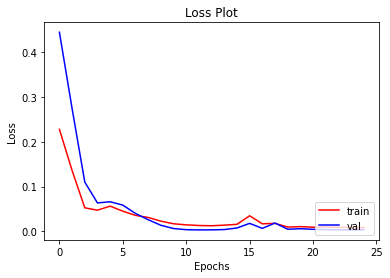

In [24]:
model,train_error,val_error = fit_model(train,val,timesteps,hl,lr,batch_size,num_epochs)
plot_error(train_error,val_error)

In [25]:
mse, rmse, r2_value, true,predicted = evaluate_model(model, test, timesteps)
print('MSE = {}'.format(mse))
print('RMSE = {}'.format(rmse))
print('R-Squared Score = {}'.format(r2_value))

MSE = 0.0024129649972450145
RMSE = 0.049121940080222956
R-Squared Score = 0.9184061498066557


In [26]:
# Get each date data
train_date = train_data.index
val_date = val_data.index
test_date = test_data.index[timesteps:]

# Bring back onto original values
train_sc = sc.inverse_transform(train)
val_sc = sc.inverse_transform(val)
test_sc = sc.inverse_transform(test)

# Create empty fill so predicted data fits with scaler dimension
zeros_shape = test.shape[0] - timesteps
num_x_variables = len(variables) - 1
empty_fill = np.zeros((zeros_shape, num_x_variables))

# Transform back into original value
pred = np.concatenate((empty_fill, predicted), axis=1)
pred = sc.inverse_transform(pred)

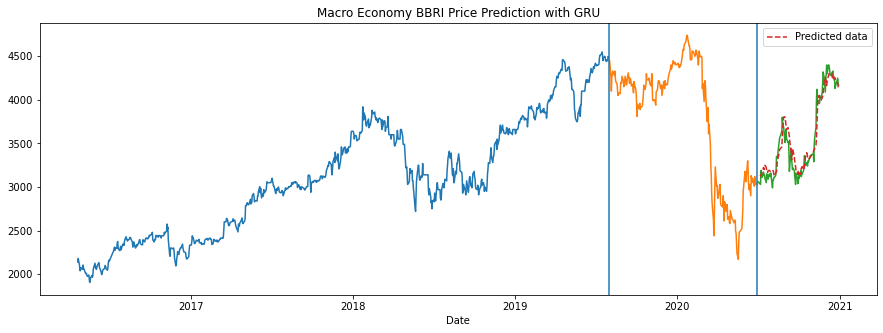

In [27]:
# Figure size
plt.figure(figsize=(15, 5))

# Train data
plt.plot(train_date, train_sc[:, 6])

# Val data
plt.plot(val_date, val_sc[:, 6])

# Test data
plt.plot(test_data.index, test_sc[:, 6])
plt.plot(test_date, pred[:, 6], label='Predicted data', linestyle='--')

# Boundaries
plt.axvline(np.max(train_date))
plt.axvline(np.max(val_date))

# Attributes
plt.title('Macro Economy BBRI Price Prediction with GRU')
plt.xlabel('Date')
plt.legend()
plt.show()

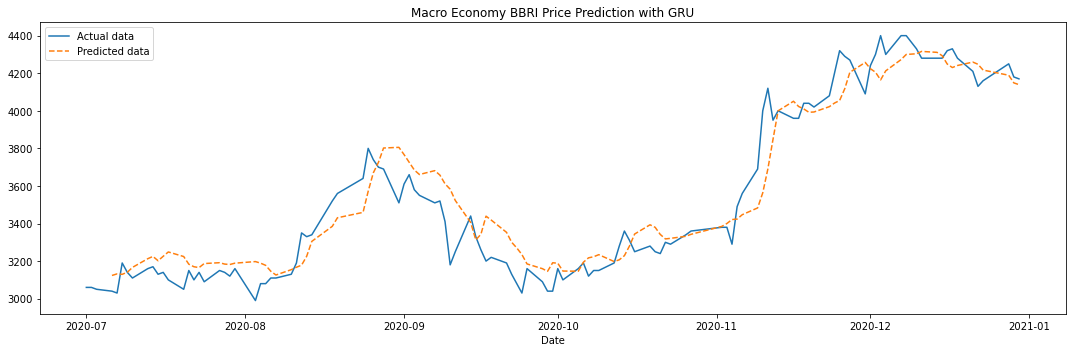

In [28]:
plt.figure(figsize=(15, 5))

# Test data
plt.plot(test_data.index, test_sc[:, 6], label='Actual data')
plt.plot(test_date, pred[:, 6], label='Predicted data', linestyle='--')

# Attributes
plt.title('Macro Economy BBRI Price Prediction with GRU')
plt.xlabel('Date')
plt.legend()
plt.tight_layout()

In [29]:
#GRU better than LSTM from the graph, MSE and RMSE also smaller than LSTM, but R2 Square is bigger than LSTM (Closer to 1)